In [1]:
import numpy as np
from scipy.stats import gaussian_kde
from scipy.interpolate import interp1d
from scipy.interpolate import RectBivariateSpline
from scipy.interpolate import UnivariateSpline
import h5py
import os,sys
import astropy.cosmology as cosmo
import astropy.units as u
from astropy.cosmology import Planck15
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import json
import glob
import copy
import re
import pickle

import sys
#sys.path.append('/home/thomas.callister/CBC/effective-spin-priors/')
#from priors import chi_effective_prior_from_isotropic_spins
#from priors import joint_prior_from_isotropic_spins

output_path = "preprocessed-single-events-rerun/"
import os
if output_path[:-1] not in os.listdir('./'):
    os.makedirs(output_path)

In [2]:
#This is copy-paste code from '/home/thomas.callister/CBC/effective-spin-priors/priors.py'
import numpy as np
from scipy.stats import gaussian_kde
from scipy.special import spence as PL

def Di(z):

    """
    Wrapper for the scipy implmentation of Spence's function.
    Note that we adhere to the Mathematica convention as detailed in:
    https://reference.wolfram.com/language/ref/PolyLog.html

    Inputs
    z: A (possibly complex) scalar or array

    Returns
    Array equivalent to PolyLog[2,z], as defined by Mathematica
    """

    return PL(1.-z+0j)

def chi_effective_prior_from_aligned_spins(q,aMax,xs):

    """
    Function defining the conditional priors p(chi_eff|q) corresponding to
    uniform, aligned component spin priors.

    Inputs
    q: Mass ratio value (according to the convention q<1)
    aMax: Maximum allowed dimensionless component spin magnitude
    xs: Chi_effective value or values at which we wish to compute prior

    Returns:
    Array of prior values
    """

    # Ensure that `xs` is an array and take absolute value
    xs = np.reshape(xs,-1)

    # Set up various piecewise cases
    pdfs = np.zeros(xs.size)
    caseA = (xs>aMax*(1.-q)/(1.+q))*(xs<=aMax)
    caseB = (xs<-aMax*(1.-q)/(1.+q))*(xs>=-aMax)
    caseC = (xs>=-aMax*(1.-q)/(1.+q))*(xs<=aMax*(1.-q)/(1.+q))

    # Select relevant effective spins
    x_A = xs[caseA]
    x_B = xs[caseB]
    x_C = xs[caseC]

    pdfs[caseA] = (1.+q)**2.*(aMax-x_A)/(4.*q*aMax**2)
    pdfs[caseB] = (1.+q)**2.*(aMax+x_B)/(4.*q*aMax**2)
    pdfs[caseC] = (1.+q)/(2.*aMax)

    return pdfs

def chi_effective_prior_from_isotropic_spins(q,aMax,xs):

    """
    Function defining the conditional priors p(chi_eff|q) corresponding to
    uniform, isotropic component spin priors.

    Inputs
    q: Mass ratio value (according to the convention q<1)
    aMax: Maximum allowed dimensionless component spin magnitude
    xs: Chi_effective value or values at which we wish to compute prior

    Returns:
    Array of prior values
    """

    # Ensure that `xs` is an array and take absolute value
    xs = np.reshape(np.abs(xs),-1)

    # Set up various piecewise cases
    pdfs = np.ones(xs.size,dtype=complex)*(-1.)
    caseZ = (xs==0)
    caseA = (xs>0)*(xs<aMax*(1.-q)/(1.+q))*(xs<q*aMax/(1.+q))
    caseB = (xs<aMax*(1.-q)/(1.+q))*(xs>q*aMax/(1.+q))
    caseC = (xs>aMax*(1.-q)/(1.+q))*(xs<q*aMax/(1.+q))
    caseD = (xs>aMax*(1.-q)/(1.+q))*(xs<aMax/(1.+q))*(xs>=q*aMax/(1.+q))
    caseE = (xs>aMax*(1.-q)/(1.+q))*(xs>aMax/(1.+q))*(xs<aMax)
    caseF = (xs>=aMax)

    # Select relevant effective spins
    x_A = xs[caseA]
    x_B = xs[caseB]
    x_C = xs[caseC]
    x_D = xs[caseD]
    x_E = xs[caseE]

    pdfs[caseZ] = (1.+q)/(2.*aMax)*(2.-np.log(q))

    pdfs[caseA] = (1.+q)/(4.*q*aMax**2)*(
                    q*aMax*(4.+2.*np.log(aMax) - np.log(q**2*aMax**2 - (1.+q)**2*x_A**2))
                    - 2.*(1.+q)*x_A*np.arctanh((1.+q)*x_A/(q*aMax))
                    + (1.+q)*x_A*(Di(-q*aMax/((1.+q)*x_A)) - Di(q*aMax/((1.+q)*x_A)))
                    )

    pdfs[caseB] = (1.+q)/(4.*q*aMax**2)*(
                    4.*q*aMax
                    + 2.*q*aMax*np.log(aMax)
                    - 2.*(1.+q)*x_B*np.arctanh(q*aMax/((1.+q)*x_B))
                    - q*aMax*np.log((1.+q)**2*x_B**2 - q**2*aMax**2)
                    + (1.+q)*x_B*(Di(-q*aMax/((1.+q)*x_B)) - Di(q*aMax/((1.+q)*x_B)))
                    )

    pdfs[caseC] = (1.+q)/(4.*q*aMax**2)*(
                    2.*(1.+q)*(aMax-x_C)
                    - (1.+q)*x_C*np.log(aMax)**2.
                    + (aMax + (1.+q)*x_C*np.log((1.+q)*x_C))*np.log(q*aMax/(aMax-(1.+q)*x_C))
                    - (1.+q)*x_C*np.log(aMax)*(2. + np.log(q) - np.log(aMax-(1.+q)*x_C))
                    + q*aMax*np.log(aMax/(q*aMax-(1.+q)*x_C))
                    + (1.+q)*x_C*np.log((aMax-(1.+q)*x_C)*(q*aMax-(1.+q)*x_C)/q)
                    + (1.+q)*x_C*(Di(1.-aMax/((1.+q)*x_C)) - Di(q*aMax/((1.+q)*x_C)))
                    )

    pdfs[caseD] = (1.+q)/(4.*q*aMax**2)*(
                    -x_D*np.log(aMax)**2
                    + 2.*(1.+q)*(aMax-x_D)
                    + q*aMax*np.log(aMax/((1.+q)*x_D-q*aMax))
                    + aMax*np.log(q*aMax/(aMax-(1.+q)*x_D))
                    - x_D*np.log(aMax)*(2.*(1.+q) - np.log((1.+q)*x_D) - q*np.log((1.+q)*x_D/aMax))
                    + (1.+q)*x_D*np.log((-q*aMax+(1.+q)*x_D)*(aMax-(1.+q)*x_D)/q)
                    + (1.+q)*x_D*np.log(aMax/((1.+q)*x_D))*np.log((aMax-(1.+q)*x_D)/q)
                    + (1.+q)*x_D*(Di(1.-aMax/((1.+q)*x_D)) - Di(q*aMax/((1.+q)*x_D)))
                    )

    pdfs[caseE] = (1.+q)/(4.*q*aMax**2)*(
                    2.*(1.+q)*(aMax-x_E)
                    - (1.+q)*x_E*np.log(aMax)**2
                    + np.log(aMax)*(
                        aMax
                        -2.*(1.+q)*x_E
                        -(1.+q)*x_E*np.log(q/((1.+q)*x_E-aMax))
                        )
                    - aMax*np.log(((1.+q)*x_E-aMax)/q)
                    + (1.+q)*x_E*np.log(((1.+q)*x_E-aMax)*((1.+q)*x_E-q*aMax)/q)
                    + (1.+q)*x_E*np.log((1.+q)*x_E)*np.log(q*aMax/((1.+q)*x_E-aMax))
                    - q*aMax*np.log(((1.+q)*x_E-q*aMax)/aMax)
                    + (1.+q)*x_E*(Di(1.-aMax/((1.+q)*x_E)) - Di(q*aMax/((1.+q)*x_E)))
                    )

    pdfs[caseF] = 0.

    # Deal with spins on the boundary between cases
    if np.any(pdfs==-1):
        boundary = (pdfs==-1)
        pdfs[boundary] = 0.5*(chi_effective_prior_from_isotropic_spins(q,aMax,xs[boundary]+1e-6)\
                        + chi_effective_prior_from_isotropic_spins(q,aMax,xs[boundary]-1e-6))

    return np.real(pdfs)

def chi_p_prior_from_isotropic_spins(q,aMax,xs):

    """
    Function defining the conditional priors p(chi_p|q) corresponding to
    uniform, isotropic component spin priors.

    Inputs
    q: Mass ratio value (according to the convention q<1)
    aMax: Maximum allowed dimensionless component spin magnitude
    xs: Chi_p value or values at which we wish to compute prior

    Returns:
    Array of prior values
    """

    # Ensure that `xs` is an array and take absolute value
    xs = np.reshape(xs,-1)

    # Set up various piecewise cases
    pdfs = np.zeros(xs.size)
    caseA = xs<q*aMax*(3.+4.*q)/(4.+3.*q)
    caseB = (xs>=q*aMax*(3.+4.*q)/(4.+3.*q))*(xs<aMax)

    # Select relevant effective spins
    x_A = xs[caseA]
    x_B = xs[caseB]

    pdfs[caseA] = (1./(aMax**2*q))*((4.+3.*q)/(3.+4.*q))*(
                    np.arccos((4.+3.*q)*x_A/((3.+4.*q)*q*aMax))*(
                        aMax
                        - np.sqrt(aMax**2-x_A**2)
                        + x_A*np.arccos(x_A/aMax)
                        )
                    + np.arccos(x_A/aMax)*(
                        aMax*q*(3.+4.*q)/(4.+3.*q)
                        - np.sqrt(aMax**2*q**2*((3.+4.*q)/(4.+3.*q))**2 - x_A**2)
                        + x_A*np.arccos((4.+3.*q)*x_A/((3.+4.*q)*aMax*q))
                        )
                    )
                    
    pdfs[caseB] = (1./aMax)*np.arccos(x_B/aMax)

    return pdfs

def joint_prior_from_isotropic_spins(q,aMax,xeffs,xps,ndraws=10000,bw_method='scott'):

    """
    Function to calculate the conditional priors p(xp|xeff,q) on a set of {xp,xeff,q} posterior samples.

    INPUTS
    q: Mass ratio
    aMax: Maximimum spin magnitude considered
    xeffs: Effective inspiral spin samples
    xps: Effective precessing spin values
    ndraws: Number of draws from the component spin priors used in numerically building interpolant

    RETURNS
    p_chi_p: Array of priors on xp, conditioned on given effective inspiral spins and mass ratios
    """

    # Convert to arrays for safety
    xeffs = np.reshape(xeffs,-1)
    xps = np.reshape(xps,-1)
    
    # Compute marginal prior on xeff, conditional prior on xp, and multiply to get joint prior!
    p_chi_eff = chi_effective_prior_from_isotropic_spins(q,aMax,xeffs)
    p_chi_p_given_chi_eff = np.array([chi_p_prior_given_chi_eff_q(q,aMax,xeffs[i],xps[i],ndraws,bw_method) for i in range(len(xeffs))])
    joint_p_chi_p_chi_eff = p_chi_eff*p_chi_p_given_chi_eff

    return joint_p_chi_p_chi_eff

def chi_p_prior_given_chi_eff_q(q,aMax,xeff,xp,ndraws=10000,bw_method='scott'):

    """
    Function to calculate the conditional prior p(xp|xeff,q) on a single {xp,xeff,q} posterior sample.
    Called by `joint_prior_from_isotropic_spins`.

    INPUTS
    q: Single posterior mass ratio sample
    aMax: Maximimum spin magnitude considered
    xeff: Single effective inspiral spin sample
    xp: Single effective precessing spin value
    ndraws: Number of draws from the component spin priors used in numerically building interpolant

    RETURNS
    p_chi_p: Prior on xp, conditioned on given effective inspiral spin and mass ratio
    """

    # Draw random spin magnitudes.
    # Note that, given a fixed chi_eff, a1 can be no larger than (1+q)*chi_eff,
    # and a2 can be no larger than (1+q)*chi_eff/q
    a1 = np.random.random(ndraws)*aMax
    a2 = np.random.random(ndraws)*aMax

    # Draw random tilts for spin 2
    cost2 = 2.*np.random.random(ndraws)-1.

    # Finally, given our conditional value for chi_eff, we can solve for cost1
    # Note, though, that we still must require that the implied value of cost1 be *physical*
    cost1 = (xeff*(1.+q) - q*a2*cost2)/a1  

    # While any cost1 values remain unphysical, redraw a1, a2, and cost2, and recompute
    # Repeat as necessary
    while np.any(cost1<-1) or np.any(cost1>1):   
        to_replace = np.where((cost1<-1) | (cost1>1))[0]   
        a1[to_replace] = np.random.random(to_replace.size)*aMax
        a2[to_replace] = np.random.random(to_replace.size)*aMax
        cost2[to_replace] = 2.*np.random.random(to_replace.size)-1.    
        cost1 = (xeff*(1.+q) - q*a2*cost2)/a1   
            
    # Compute precessing spins and corresponding weights, build KDE
    # See `Joint-ChiEff-ChiP-Prior.ipynb` for a discussion of these weights
    Xp_draws = chi_p_from_components(a1,a2,cost1,cost2,q)
    jacobian_weights = (1.+q)/a1
    prior_kde = gaussian_kde(Xp_draws,weights=jacobian_weights,bw_method=bw_method)

    # Compute maximum chi_p
    if (1.+q)*np.abs(xeff)/q<aMax:
        max_Xp = aMax
    else:
        max_Xp = np.sqrt(aMax**2 - ((1.+q)*np.abs(xeff)-q)**2.)

    # Set up a grid slightly inside (0,max chi_p) and evaluate KDE
    reference_grid = np.linspace(0.02*max_Xp,0.98*max_Xp,50)
    reference_vals = prior_kde(reference_grid)

    # Manually prepend/append zeros at the boundaries
    reference_grid = np.concatenate([[0],reference_grid,[max_Xp]])
    reference_vals = np.concatenate([[0],reference_vals,[0]])
    norm_constant = np.trapz(reference_vals,reference_grid)

    # Interpolate!
    p_chi_p = np.interp(xp,reference_grid,reference_vals/norm_constant)
    return p_chi_p

def chi_p_from_components(a1,a2,cost1,cost2,q):

    """
    Helper function to define effective precessing spin parameter from component spins

    INPUTS
    a1: Primary dimensionless spin magnitude
    a2: Secondary's spin magnitude
    cost1: Cosine of the primary's spin-orbit tilt angle
    cost2: Cosine of the secondary's spin-orbit tilt
    q: Mass ratio

    RETRUNS
    chi_p: Corresponding precessing spin value
    """

    sint1 = np.sqrt(1.-cost1**2)
    sint2 = np.sqrt(1.-cost2**2)
    
    return np.maximum(a1*sint1,((3.+4.*q)/(4.+3.*q))*q*a2*sint2)

In [3]:
import numpy as np
import scipy

def Joint_prob_Xeff_Xp(Xeff,Xp,q = 1,amax = 1,flag_debug = False):
    r'''
    Returns Joint prior on Effective Spin parameter Xeff and Precessing Spin Parameter Xp,
    given Mass ratio q, Max allowed spin magnitude amax, $p(Xeff,Xp|q,amax)$.
    Assumes $q>0$ and $0<amax<=1.$ $q>1$ inputs are interepreted as $1/q$.
    if flag_debug is True, then the function shows some integration for debugging and returns 4 integrals separately.
    '''
    assert (amax <= 1)*(amax > 0),"Invalid amax. 0<amax<=1 is accepted."
    
    def S(z):
        r'''
        Spence's function or dilogarithm Li_2(z).
        '''
        return scipy.special.spence(1-z)

    def g(x0,a0,b0):
        r'''
        Primitive function of log(x-bi)/(x-a-i) (x>=0).
        '''                    
        ans = np.zeros(len(a0))+0j
        case_special = (b0 == 0)*(x0 == 0)
        case_b_less_1 = (np.abs(b0) < 1)*(np.logical_not(case_special))
        case_b_1_a_less_0 = (b0 == 1)*(a0 <= 0)
        case_otherwise = np.logical_not(case_b_less_1|case_b_1_a_less_0|case_special)
        
        for j, case in enumerate([case_special,case_b_less_1,case_b_1_a_less_0,case_otherwise]):
            if np.any(case):
                x = x0[case]
                a = a0[case]
                b = b0[case]
                if j == 0:
                    ans[case] = 0
                if j == 1:
                    ans[case] = np.log(x-b*1j)*np.log((a-x+1j)/(a+1j-b*1j))+S((x-b*1j)/(a+1j-b*1j))
                if j == 2:
                    ans[case] = 1/2*(np.log(x-a-1j))**2+S(-a/(x-a-1j))
                if j == 3:
                    ans[case] = np.log(a+1j-b*1j)*np.log(a-x+1j)-S((a-x+1j)/(a+1j-b*1j))
        return ans
        
        

    def G(x0,a0,b0):
        r'''
        \int_0^x((x^2+b^2))/(1+(x-a)^2) dx.
        '''
        
        case_positive_x = (x0 > 0)
        case_negative_x = (x0 < 0)
        ans = np.zeros(len(x0))
        
        for j,case in enumerate([case_positive_x,case_negative_x]):
            if np.any(case):
                x = x0[case]
                a = a0[case]
                b = b0[case]
                if j == 0:
                    if flag_debug:
                        print("Given Values to H(x,a,b):")
                        print('x',x)
                        print('a',a)
                        print('b',b)
                        print('')
                    ans[case] = np.imag(g(x,a,b)+g(x,a,-b))-np.imag(g(np.zeros(len(x)),a,b)+g(np.zeros(len(x)),a,-b))
                if j == 1:
                    if flag_debug:
                        print('Avoid x<0 by transposing.')
                    ans[case] = -G(-x,-a,b)
        return ans

    def F(_x,_a,_b,_c,_d):
        r'''
        \int_0^x b*log((x^2+c^2)/d^2)/(b^2+(x-a)^2) dx.
        '''
        if np.any(_d == 0):
            print('Something is wrong!')
            raise ValueError
            
        x0 = np.atleast_1d(_x)
        a0 = np.atleast_1d(_a)
        b0 = np.atleast_1d(_b)
        c0 = np.atleast_1d(_c)
        d0 = np.atleast_1d(_d)
        max_len = len(b0)
        arr = np.zeros((5,max_len))
        for j, X in enumerate([x0,a0,b0,c0,d0]):
            if X.shape[0] == 1:
                arr[j,:] = X[0]
            else:
                arr[j,:] = X[:]
        x0,a0,b0,c0,d0 = arr
        
        if flag_debug:
            print(x0,a0,b0,c0,d0)
        ans = np.zeros(len(b0))
        case = (b0 != 0)
        x = x0[case]
        a = a0[case]
        b = b0[case]
        c = c0[case]
        d = d0[case]
        ans[case] = G(x/b,a/b,c/b) + np.log(b*b/d/d)*(np.arctan(a/b)+np.arctan((x-a)/b))
        return ans


    def Joint_prob_Xeff_Xp_1(_Xeff,_Xp,_q,flag_debug):
        r'''
        Returns Joint prior on Effective Spin parameter Xeff and Precessing Spin Parameter Xp, given Mass ratio q.
        Max allowed spin magnitude amax is assumed to be amax=1.
        '''
        Xp = np.atleast_1d(_Xp)
        Xeff = np.atleast_1d(_Xeff)
        q = np.atleast_1d(_q)
        assert np.min(q) > 0
        q[q>1] = 1/q[q>1]
    
        zeta = (1+q)*Xeff
        nu = (4+3*q)/(3+4*q)
    
        max_len = np.max([Xp.shape[0],Xeff.shape[0],q.shape[0]])
        arr = np.zeros((5,max_len))
        for j, X in enumerate([Xeff,Xp,q,zeta,nu]):
            if X.shape[0] == 1:
                arr[j,:] = X[0]
            else:
                arr[j,:] = X[:]
            
        Xeff0,Xp0,q0,zeta0,nu0 = arr
        threshold = q0/nu0
    
        case_OoB = np.logical_or((Xp0 <= 0),(Xp0 >= 1))
        case_lsr_than_threshold = np.logical_and(np.logical_not(case_OoB),(Xp0 < threshold))
        case_gtr_than_threshold = np.logical_and(np.logical_not(case_OoB),(Xp0 >= threshold))
    
        #Joint PDF is a sum of 4 integrals
        int_1 = np.zeros(max_len)
        int_2 = np.zeros(max_len)
        int_3 = np.zeros(max_len)
        int_4 = np.zeros(max_len)
    
        for j,case in enumerate([case_OoB,
                                case_lsr_than_threshold,
                                case_gtr_than_threshold]):
            if np.any(case):
                Xeff = Xeff0[case]
                Xp = Xp0[case]
                q = q0[case]
                zeta = zeta0[case]
                nu = nu0[case]
            
                if j != 0:
                #Only int_2 have non-zero value for j = 2
                    max_2 = np.minimum(zeta+np.sqrt(1-Xp*Xp),q)
                    min_2 = np.maximum(zeta-np.sqrt(1-Xp*Xp),-q)
                    zero = (min_2 > max_2)
                    if np.any(zero):
                        max_2[zero] = min_2[zero]
                    if flag_debug:
                        print('Calculating 2nd integral for j = {}'.format(j))
                        print('x_max:',max_2)
                        print('x_min:',min_2)
                    int_2[case] = -(1+q)/8/q * (F(max_2,zeta,Xp,0,q)-F(min_2,zeta,Xp,0,q))
                
                #int_1,int_3,int_4 have none-zero value only if j = 1
                    if j == 1:
                    
                        #int_1
                        max_1 = np.minimum(zeta+np.sqrt(1-Xp*Xp),np.sqrt(q*q-nu*nu*Xp*Xp))
                        min_1 = np.maximum(zeta-np.sqrt(1-Xp*Xp),-np.sqrt(q*q-nu*nu*Xp*Xp))
                        zero = (min_1 > max_1)                            
                        if np.any(zero):
                            max_1[zero] = min_1[zero]
                        if flag_debug:
                            print('Calculating 1st integral')
                            print('x_max:',max_1)
                            print('x_min:',min_1)
                        int_1[case] = (1+q)/8/q * (F(max_1,zeta,Xp,nu*Xp,q)-F(min_1,zeta,Xp,nu*Xp,q))
                    
                        #int_3
                        max_3 = np.minimum(zeta+np.sqrt(q*q-nu*nu*Xp*Xp),np.sqrt(1-Xp*Xp))
                        min_3 = np.maximum(zeta-np.sqrt(q*q-nu*nu*Xp*Xp),-np.sqrt(1-Xp*Xp))
                        zero = (min_3 > max_3)
                        if np.any(zero):
                            max_3[zero] = min_3[zero]
                        if flag_debug:
                            print('Calculating 3rd integral')
                            print('x_max:',max_3)
                            print('x_min:',min_3)
                        int_3[case] = (1+q)*nu/8/q * (F(max_3,zeta,nu*Xp,Xp,1)-F(min_3,zeta,nu*Xp,Xp,1))
                    
                        #int_4
                        max_4 = np.minimum(zeta+np.sqrt(q*q-nu*nu*Xp*Xp),q/q)
                        min_4 = np.maximum(zeta-np.sqrt(q*q-nu*nu*Xp*Xp),-q/q)
                        zero = (min_4 > max_4)
                        if np.any(zero):
                            max_4[zero] = min_4[zero]
                        if flag_debug:
                            print('Calculating 4th integral')
                            print('x_max:',max_4)
                            print('x_min:',min_4)
                        int_4[case] = -(1+q)*nu/8/q * (F(max_4,zeta,nu*Xp,0,1)-F(min_4,zeta,nu*Xp,0,1))
                    
        if flag_debug:
            return int_1,int_2,int_3,int_4
        elif max_len == 1:
            return (int_1+int_2+int_3+int_4)[0]
        return int_1+int_2+int_3+int_4
    
    if flag_debug:
        int_1,int_2,int_3,int_4 = Joint_prob_Xeff_Xp_1(Xeff/amax,Xp/amax,q,flag_debug)
        return int_1/amax/amax,int_2/amax/amax,int_3/amax/amax,int_4/amax/amax
    return Joint_prob_Xeff_Xp_1(Xeff/amax,Xp/amax,q,flag_debug)/amax/amax


# Prelim

First, define some helper functions to compute chi_effective and chi_p

In [4]:
def Calculate_Xp(m1, m2, a1, a2, costilt1, costilt2):
    
    q = m2/m1
    sintilt1 = np.sqrt(1-(costilt1)**2)
    sintilt2 = np.sqrt(1-(costilt2)**2)
    
    return np.maximum(a1*sintilt1, (3.+4.*q)/(4.+3.*q)*q*a2*sintilt2)

def Calculate_Xeff(m1, m2, a1, a2, costilt1, costilt2):
    Xeff = (m1*a1*costilt1 + m2*a2*costilt2)/(m1+m2)
    return Xeff

def eta(m1,m2):
    return m1*m2/(m1+m2)/(m1+m2)

def Mc(m1,m2):
    return np.power(eta(m1,m2),3./5.)*(m1+m2)

We'll additionally be reweighting the default LALInference mass and redshift priors with more astrophysically-motivated priors. The LALInference prior is uniform in *luminosity* distance, and uniform in *detector-frame* component masses. This corresponds to:

\begin{equation}
p_\mathrm{lal}(m_1,m_2,z) \propto (1+z)^2 D_L^2(z) \left( D_c(z) + \frac{c(1+z)}{H(z)}\right),
\end{equation}

where $D_L(z)$ and $D_c(z)$ are the luminosity and comoving distance at redshift $z$, respectively, and $H(z)$ is the Hubble parameter at $z$.

We'll reweight to a prior that assumes the (source-frame) comoving merger rate density evolves as $(1+z)^{2.7}$, with a flat prior over *source frame* masses:

\begin{equation}
p_\mathrm{astro}(m_1,m_2,z) \propto \frac{1}{1+z} \left(1+z\right)^{2.7} \frac{dV_c}{dz}
\end{equation}

In [5]:
# Define constants
# Note that we assume a cosmology identical to that in pesummary
c = 299792458 # m/s
H_0 = 67900.0 # m/s/MPc
Omega_M = 0.3065 # unitless
Omega_Lambda = 1.0-Omega_M
year = 365.25*24.*3600

# Construct custom cosmology matching pesummary
cosmo = Planck15.clone(name='cosmo',Om0=Omega_M,H0=H_0/1e3,Tcmb0=0.)

def Hz(z):
    return H_0*np.sqrt(Omega_M*(1.+z)**3.+Omega_Lambda)

def calculate_pLAL(z, dl):
    dc = dl/(1.+z) # comoving distance 
    pLAL = np.power(1.+z,2.)*np.power(dl,2.)*(dc+c*(1.+z)/Hz(z))
    return pLAL

def calculate_pASTRO(z, dl):
    dc = dl/(1.+z) # comoving distance 
    dVc_dz = 4*np.pi*c*(dc**2.)/Hz(z) # comoving volume 
    pASTRO = np.power(1.+z,1.7)*dVc_dz
    return pASTRO

For later use, we'll want to build an interpolant between luminosity distance and redshift:

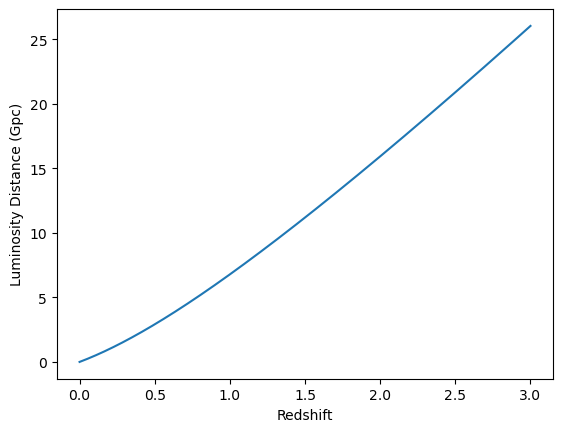

In [6]:
zs_ref = np.linspace(0.,3.,1000)
DL_ref = cosmo.luminosity_distance(zs_ref).to(u.Mpc).value

fig,ax = plt.subplots()
ax.plot(zs_ref,DL_ref/1e3)
ax.set_xlabel('Redshift')
ax.set_ylabel('Luminosity Distance (Gpc)')
plt.show()

Finally, load dictionary we'll use to list events and cut on FAR

<span style="color: red; ">ここが変わっています</span>

In [7]:
#eventDict = h5py.File('/home/thomas.callister/CBC/o3b-astro-dist/events.hdf','r')
eventDict = h5py.File('../other_files/events.hdf','r')

#eventKeyFile = "/home/thomas.callister/CBC/o3b-astro-dist/bin/fetch_o3b_pe_for_rp/event_to_run.json"
eventKeyFile = "../other_files/event_to_run.json"
with open(eventKeyFile,'r') as jf:
    eventKeyDict = json.load(jf)

target_nSamps = 4000000

# O1/O2

In [8]:
O1O2_events = np.array([])

for key in eventDict['O1']:
    O1O2_events = np.append(O1O2_events,str(key))
    
for key in eventDict['O2']:
    if key!='GW170817':
        O1O2_events = np.append(O1O2_events,str(key))
    
print(O1O2_events)

['GW150914' 'GW151012' 'GW151226' 'GW170104' 'GW170608' 'GW170729'
 'GW170809' 'GW170814' 'GW170818' 'GW170823']


<span style="color: red; ">ここが変わっています</span>

In [9]:
for key  in O1O2_events:
    
    print(key)
    
    #if os.path.exists("preprocessed-single-events-11-29/{0}.npy".format(key)):
    if os.path.exists(output_path+"{0}.npy".format(key)):
        print("skip")
        continue
    
    # load samples
    
    #BBH_post = h5py.File('/home/shanika.galaudage/O3/population/GWTC-1_sample_release/{0}_GWTC-1.hdf5'.format(key), 'r')['Overall_posterior']
    BBH_post = h5py.File('../other_files/GWTC-1_Sample_Release/{0}_GWTC-1.hdf5'.format(key), 'r')['Overall_posterior']
    m1_DF = BBH_post['m1_detector_frame_Msun']
    m2_DF = BBH_post['m2_detector_frame_Msun']
    a1 = BBH_post['spin1']
    a2 = BBH_post['spin2']
    cost1 = BBH_post['costilt1']
    cost2 = BBH_post['costilt2']
    
    Xeff = Calculate_Xeff(m1_DF,m2_DF,a1,a2,cost1,cost2)
    Xp = Calculate_Xp(m1_DF,m2_DF,a1,a2,cost1,cost2)
    DL = BBH_post['luminosity_distance_Mpc']
    
    # Downselect to a reasonable number of samples
    nSamps = min(target_nSamps,Xeff.size)
    sampleDraws = np.random.choice(np.arange(Xeff.size),size=nSamps,replace=False)
    m1_DF = m1_DF[sampleDraws]
    m2_DF = m2_DF[sampleDraws]
    Xeff = Xeff[sampleDraws]
    Xp = Xp[sampleDraws]
    DL = DL[sampleDraws]
    a1 = a1[sampleDraws]
    a2 = a2[sampleDraws]
    cost1 = cost1[sampleDraws]
    cost2 = cost2[sampleDraws]
      
    # Mass ratio
    q = m2_DF/m1_DF

    # Evaluate chi_eff/chi_p priors
    Xeff_priors = np.ones(q.size)
    joint_priors = np.ones(q.size)
    for i in tqdm(range(q.size)):
        #joint_priors[i] = joint_prior_from_isotropic_spins(q[i],1.,Xeff[i],Xp[i])
        joint_priors[i] = joint_prior_from_isotropic_spins(q[i],1.,Xeff[i],Xp[i])[0]
        #Xeff_priors[i] = chi_effective_prior_from_isotropic_spins(q[i],1.,Xeff[i])
        Xeff_priors[i] = chi_effective_prior_from_isotropic_spins(q[i],1.,Xeff[i])[0]
    joint_priors_a = Joint_prob_Xeff_Xp(Xeff,Xp,q = q,amax = 1,flag_debug = False)
    
    # Redshift and mass priors
    # Note that DL is the observable, and so our mapping to z is model dependent
    z = np.interp(DL,DL_ref,zs_ref)
    Dc = DL/(1.+z)
    pAstro = calculate_pASTRO(z,DL)
    pAstro[pAstro<0] = 0 # if pASTRO < 0, make pASTRO = 0
    p_LAL = calculate_pLAL(z, DL)

    weights = pAstro/p_LAL
    labels = ['K','A']
    for i,j in enumerate([joint_priors,joint_priors_a]):
        preprocDict = {'Xeff':Xeff,\
                       'Xp':Xp,\
                       'joint_priors':j,\
                       'Xeff_priors':Xeff_priors,\
                       'weights':weights,\
                       'm1':m1_DF/(1.+z),\
                       'm2':m2_DF/(1.+z),\
                       'a1':a1,\
                       'a2':a2,\
                       'cost1':cost1,\
                       'cost2':cost2,\
                       'z':z
                       }
        #np.save('preprocessed-single-events-11-29/{0}.npy'.format(key),preprocDict)
        np.save(output_path+'{0}_{1}.npy'.format(key,labels[i]),preprocDict)

GW150914


  0%|          | 0/8350 [00:00<?, ?it/s]

GW151012


  0%|          | 0/16096 [00:00<?, ?it/s]

GW151226


  0%|          | 0/52252 [00:00<?, ?it/s]

GW170104


  0%|          | 0/24972 [00:00<?, ?it/s]

GW170608


  0%|          | 0/6448 [00:00<?, ?it/s]

GW170729


  0%|          | 0/5112 [00:00<?, ?it/s]

GW170809


  0%|          | 0/14802 [00:00<?, ?it/s]

GW170814


  0%|          | 0/40000 [00:00<?, ?it/s]

GW170818


  0%|          | 0/5862 [00:00<?, ?it/s]

GW170823


  0%|          | 0/4278 [00:00<?, ?it/s]

# O3

<span style="color: red; ">eventDict['O3'][key]['FAR']['minfar'].valueは現在のpythonでは読み込めないので、書式変更</span>

In [10]:
O3_events = np.array([])

# GW190425 is a BNS
# GW190426, GW200105, and GW200115 are NSBH candidates
# GW190917 is a mass gap event
to_exclude = ['S190425z','S190426c','S190917u','S200105ae','S200115j']
for key in eventDict['O3']:
    if key not in to_exclude:
        
        if key=="%s":
            continue
        
        #print(key)
        #FAR_in_years = float(eventDict['O3'][key]['FAR']['minfar'].value)*year
        FAR_in_years = float(eventDict['O3'][key]['FAR']['minfar'][()])*year
        if FAR_in_years<=1.:
            O3_events = np.append(O3_events,str(key))
    
print(len(O3_events))
#print(O3_events)

60


In [11]:
for event in O3_events:
    
    #hfile = "/home/richard.oshaughnessy/public_html/O3/o3b_snapshots/GWTC-3_2021-11-08_revised/snapshot/{0}.h5".format(event)
    hfile = "../other_files/GWTC-3_Sample_Release/{0}.h5".format(event)
    if not os.path.isfile(hfile):
        print("Cannot find file",event)
        continue
        
    #if os.path.exists("preprocessed-single-events-11-29/{0}.npy".format(event)):
    if os.path.exists(output_path+"{0}.npy".format(event)):
        print("skip")
        continue
        
    f = h5py.File(hfile,'r')
    print(event)
    print(hfile)
    
    pe_key = eventKeyDict[event]
    print(pe_key)
    BBH_post_samples = f[pe_key]['posterior_samples']
    
    m1_SF = BBH_post_samples['mass_1_source']
    m2_SF = BBH_post_samples['mass_2_source']
    a1 = BBH_post_samples['a_1']
    a2 = BBH_post_samples['a_2']
    cost1 = BBH_post_samples['cos_tilt_1']
    cost2 = BBH_post_samples['cos_tilt_2']
    DL = BBH_post_samples['luminosity_distance']
    z = BBH_post_samples['redshift']
    
    Xeff = Calculate_Xeff(m1_SF,m2_SF,a1,a2,cost1,cost2)
    Xp = Calculate_Xp(m1_SF,m2_SF,a1,a2,cost1,cost2)
            
    # Downselect to a reasonable number of samples
    #if event=='S190517h' or event=='S190519bj':
    #    nSamps = min(8000,Xeff.size)
    #else:
    #    nSamps = min(target_nSamps,Xeff.size)
    nSamps = min(target_nSamps,Xeff.size)
    print(nSamps)
        
    sampleDraws = np.random.choice(np.arange(Xeff.size),size=nSamps,replace=False)
    m1_SF = m1_SF[sampleDraws]
    m2_SF = m2_SF[sampleDraws]
    Xeff = Xeff[sampleDraws]
    Xp = Xp[sampleDraws]
    DL = DL[sampleDraws]
    z = z[sampleDraws]
    a1 = a1[sampleDraws]
    a2 = a2[sampleDraws]
    cost1 = cost1[sampleDraws]
    cost2 = cost2[sampleDraws]
    
    # Mass ratio
    q = m2_SF/m1_SF
    
    Xeff_priors = np.ones(q.size)
    joint_priors = np.ones(q.size)
    for i in tqdm(range(q.size)):
        #joint_priors[i] = joint_prior_from_isotropic_spins(q[i],1.,Xeff[i],Xp[i])
        joint_priors[i] = joint_prior_from_isotropic_spins(q[i],1.,Xeff[i],Xp[i])[0]
        #Xeff_priors[i] = chi_effective_prior_from_isotropic_spins(q[i],1.,Xeff[i])
        Xeff_priors[i] = chi_effective_prior_from_isotropic_spins(q[i],1.,Xeff[i])[0]
    print('where_joint_prior_is_NaN:',np.where(np.isnan(joint_priors)))
    print('where_joint_prior_is_ZERO:',np.where(joint_priors==0))
    joint_priors_a = Joint_prob_Xeff_Xp(Xeff,Xp,q = q,amax = 1,flag_debug = False)

    # Redshift and mass priors
    Dc = DL/(1.+z)
    pAstro = calculate_pASTRO(z,DL)
    pAstro[pAstro<0] = 0 # if pASTRO < 0, make pASTRO = 0
    p_LAL = calculate_pLAL(z, DL)

    weights = pAstro/p_LAL    
    labels = ['K','A']
    for i,j in enumerate([joint_priors,joint_priors_a]):
        preprocDict = {'Xeff':Xeff,\
                       'Xp':Xp,\
                       'joint_priors':j,\
                       'Xeff_priors':Xeff_priors,\
                       'weights':weights,\
                       'm1':m1_SF,\
                       'm2':m2_SF,\
                       'a1':a1,\
                       'a2':a2,\
                       'cost1':cost1,\
                       'cost2':cost2,\
                       'z':z
                       }
        #np.save('preprocessed-single-events-11-29/{0}.npy'.format(event),preprocDict)
        np.save(output_path+'{0}_{1}.npy'.format(event,labels[i]),preprocDict)

S190408an
../other_files/GWTC-3_Sample_Release/S190408an.h5
PrecessingSpinIMRHM
37366


  0%|          | 0/37366 [00:00<?, ?it/s]

where_joint_prior_is_NaN: (array([], dtype=int64),)
where_joint_prior_is_ZERO: (array([], dtype=int64),)
S190412m
../other_files/GWTC-3_Sample_Release/S190412m.h5
PrecessingSpinIMRHM
23984


  0%|          | 0/23984 [00:00<?, ?it/s]

where_joint_prior_is_NaN: (array([], dtype=int64),)
where_joint_prior_is_ZERO: (array([], dtype=int64),)
S190413ac
../other_files/GWTC-3_Sample_Release/S190413ac.h5
PrecessingSpinIMRHM
38056


  0%|          | 0/38056 [00:00<?, ?it/s]

where_joint_prior_is_NaN: (array([], dtype=int64),)
where_joint_prior_is_ZERO: (array([], dtype=int64),)
S190413i
../other_files/GWTC-3_Sample_Release/S190413i.h5
PrecessingSpinIMRHM
58046


  0%|          | 0/58046 [00:00<?, ?it/s]

where_joint_prior_is_NaN: (array([], dtype=int64),)
where_joint_prior_is_ZERO: (array([], dtype=int64),)
S190421ar
../other_files/GWTC-3_Sample_Release/S190421ar.h5
PrecessingSpinIMRHM
76712


  0%|          | 0/76712 [00:00<?, ?it/s]

where_joint_prior_is_NaN: (array([], dtype=int64),)
where_joint_prior_is_ZERO: (array([], dtype=int64),)
S190503bf
../other_files/GWTC-3_Sample_Release/S190503bf.h5
PrecessingSpinIMRHM
37669


  0%|          | 0/37669 [00:00<?, ?it/s]

where_joint_prior_is_NaN: (array([], dtype=int64),)
where_joint_prior_is_ZERO: (array([], dtype=int64),)
S190512at
../other_files/GWTC-3_Sample_Release/S190512at.h5
PrecessingSpinIMRHM
37247


  0%|          | 0/37247 [00:00<?, ?it/s]

where_joint_prior_is_NaN: (array([], dtype=int64),)
where_joint_prior_is_ZERO: (array([], dtype=int64),)
S190513bm
../other_files/GWTC-3_Sample_Release/S190513bm.h5
PrecessingSpinIMRHM
39072


  0%|          | 0/39072 [00:00<?, ?it/s]

where_joint_prior_is_NaN: (array([], dtype=int64),)
where_joint_prior_is_ZERO: (array([], dtype=int64),)
S190517h
../other_files/GWTC-3_Sample_Release/S190517h.h5
PrecessingSpinIMRHM
36932


  0%|          | 0/36932 [00:00<?, ?it/s]

where_joint_prior_is_NaN: (array([], dtype=int64),)
where_joint_prior_is_ZERO: (array([], dtype=int64),)
S190519bj
../other_files/GWTC-3_Sample_Release/S190519bj.h5
PrecessingSpinIMRHM
39976


  0%|          | 0/39976 [00:00<?, ?it/s]

where_joint_prior_is_NaN: (array([], dtype=int64),)
where_joint_prior_is_ZERO: (array([], dtype=int64),)
S190521g
../other_files/GWTC-3_Sample_Release/S190521g.h5
PrecessingSpinIMRHM
59466


  0%|          | 0/59466 [00:00<?, ?it/s]

where_joint_prior_is_NaN: (array([], dtype=int64),)
where_joint_prior_is_ZERO: (array([], dtype=int64),)
S190521r
../other_files/GWTC-3_Sample_Release/S190521r.h5
PrecessingSpinIMRHM
39836


  0%|          | 0/39836 [00:00<?, ?it/s]

where_joint_prior_is_NaN: (array([], dtype=int64),)
where_joint_prior_is_ZERO: (array([], dtype=int64),)
S190527w
../other_files/GWTC-3_Sample_Release/S190527w.h5
PrecessingSpinIMRHM
38129


  0%|          | 0/38129 [00:00<?, ?it/s]

where_joint_prior_is_NaN: (array([], dtype=int64),)
where_joint_prior_is_ZERO: (array([], dtype=int64),)
S190602aq
../other_files/GWTC-3_Sample_Release/S190602aq.h5
PrecessingSpinIMRHM
39996


  0%|          | 0/39996 [00:00<?, ?it/s]

where_joint_prior_is_NaN: (array([], dtype=int64),)
where_joint_prior_is_ZERO: (array([], dtype=int64),)
S190620e
../other_files/GWTC-3_Sample_Release/S190620e.h5
PrecessingSpinIMRHM
39290


  0%|          | 0/39290 [00:00<?, ?it/s]

where_joint_prior_is_NaN: (array([], dtype=int64),)
where_joint_prior_is_ZERO: (array([], dtype=int64),)
S190630ag
../other_files/GWTC-3_Sample_Release/S190630ag.h5
PrecessingSpinIMRHM
38720


  0%|          | 0/38720 [00:00<?, ?it/s]

where_joint_prior_is_NaN: (array([], dtype=int64),)
where_joint_prior_is_ZERO: (array([], dtype=int64),)
S190701ah
../other_files/GWTC-3_Sample_Release/S190701ah.h5
PrecessingSpinIMRHM
39996


  0%|          | 0/39996 [00:00<?, ?it/s]

where_joint_prior_is_NaN: (array([], dtype=int64),)
where_joint_prior_is_ZERO: (array([], dtype=int64),)
S190706ai
../other_files/GWTC-3_Sample_Release/S190706ai.h5
PrecessingSpinIMRHM
36176


  0%|          | 0/36176 [00:00<?, ?it/s]

where_joint_prior_is_NaN: (array([], dtype=int64),)
where_joint_prior_is_ZERO: (array([], dtype=int64),)
S190707q
../other_files/GWTC-3_Sample_Release/S190707q.h5
PrecessingSpinIMRHM
32634


  0%|          | 0/32634 [00:00<?, ?it/s]

where_joint_prior_is_NaN: (array([], dtype=int64),)
where_joint_prior_is_ZERO: (array([], dtype=int64),)
S190708ap
../other_files/GWTC-3_Sample_Release/S190708ap.h5
PrecessingSpinIMRHM
37981


  0%|          | 0/37981 [00:00<?, ?it/s]

where_joint_prior_is_NaN: (array([], dtype=int64),)
where_joint_prior_is_ZERO: (array([], dtype=int64),)
S190719an
../other_files/GWTC-3_Sample_Release/S190719an.h5
PrecessingSpinIMRHM
38698


  0%|          | 0/38698 [00:00<?, ?it/s]

where_joint_prior_is_NaN: (array([], dtype=int64),)
where_joint_prior_is_ZERO: (array([], dtype=int64),)
S190720a
../other_files/GWTC-3_Sample_Release/S190720a.h5
PrecessingSpinIMRHM
34005


  0%|          | 0/34005 [00:00<?, ?it/s]

where_joint_prior_is_NaN: (array([], dtype=int64),)
where_joint_prior_is_ZERO: (array([], dtype=int64),)
S190725t
../other_files/GWTC-3_Sample_Release/S190725t.h5
PrecessingSpinIMRHM
39522


  0%|          | 0/39522 [00:00<?, ?it/s]

where_joint_prior_is_NaN: (array([], dtype=int64),)
where_joint_prior_is_ZERO: (array([], dtype=int64),)
S190727h
../other_files/GWTC-3_Sample_Release/S190727h.h5
PrecessingSpinIMRHM
35709


  0%|          | 0/35709 [00:00<?, ?it/s]

where_joint_prior_is_NaN: (array([], dtype=int64),)
where_joint_prior_is_ZERO: (array([], dtype=int64),)
S190728q
../other_files/GWTC-3_Sample_Release/S190728q.h5
PrecessingSpinIMRHM
37230


  0%|          | 0/37230 [00:00<?, ?it/s]

where_joint_prior_is_NaN: (array([], dtype=int64),)
where_joint_prior_is_ZERO: (array([], dtype=int64),)
S190731aa
../other_files/GWTC-3_Sample_Release/S190731aa.h5
PrecessingSpinIMRHM
38323


  0%|          | 0/38323 [00:00<?, ?it/s]

where_joint_prior_is_NaN: (array([], dtype=int64),)
where_joint_prior_is_ZERO: (array([], dtype=int64),)
S190803e
../other_files/GWTC-3_Sample_Release/S190803e.h5
PrecessingSpinIMRHM
38200


  0%|          | 0/38200 [00:00<?, ?it/s]

where_joint_prior_is_NaN: (array([], dtype=int64),)
where_joint_prior_is_ZERO: (array([], dtype=int64),)
S190805bq
../other_files/GWTC-3_Sample_Release/S190805bq.h5
PrecessingSpinIMRHM
75756


  0%|          | 0/75756 [00:00<?, ?it/s]

where_joint_prior_is_NaN: (array([], dtype=int64),)
where_joint_prior_is_ZERO: (array([], dtype=int64),)
S190814bv
../other_files/GWTC-3_Sample_Release/S190814bv.h5
PrecessingSpinIMRHM
27736


  0%|          | 0/27736 [00:00<?, ?it/s]

where_joint_prior_is_NaN: (array([], dtype=int64),)
where_joint_prior_is_ZERO: (array([], dtype=int64),)
S190828j
../other_files/GWTC-3_Sample_Release/S190828j.h5
PrecessingSpinIMRHM
39692


  0%|          | 0/39692 [00:00<?, ?it/s]

where_joint_prior_is_NaN: (array([], dtype=int64),)
where_joint_prior_is_ZERO: (array([], dtype=int64),)
S190828l
../other_files/GWTC-3_Sample_Release/S190828l.h5
PrecessingSpinIMRHM
19991


  0%|          | 0/19991 [00:00<?, ?it/s]

where_joint_prior_is_NaN: (array([], dtype=int64),)
where_joint_prior_is_ZERO: (array([], dtype=int64),)
S190910s
../other_files/GWTC-3_Sample_Release/S190910s.h5
PrecessingSpinIMRHM
37784


  0%|          | 0/37784 [00:00<?, ?it/s]

where_joint_prior_is_NaN: (array([], dtype=int64),)
where_joint_prior_is_ZERO: (array([], dtype=int64),)
S190915ak
../other_files/GWTC-3_Sample_Release/S190915ak.h5
PrecessingSpinIMRHM
37836


  0%|          | 0/37836 [00:00<?, ?it/s]

where_joint_prior_is_NaN: (array([], dtype=int64),)
where_joint_prior_is_ZERO: (array([], dtype=int64),)
S190924h
../other_files/GWTC-3_Sample_Release/S190924h.h5
PrecessingSpinIMRHM
37300


  0%|          | 0/37300 [00:00<?, ?it/s]

where_joint_prior_is_NaN: (array([], dtype=int64),)
where_joint_prior_is_ZERO: (array([], dtype=int64),)
S190925ad
../other_files/GWTC-3_Sample_Release/S190925ad.h5
PrecessingSpinIMRHM
73900


  0%|          | 0/73900 [00:00<?, ?it/s]

where_joint_prior_is_NaN: (array([], dtype=int64),)
where_joint_prior_is_ZERO: (array([], dtype=int64),)
S190929d
../other_files/GWTC-3_Sample_Release/S190929d.h5
PrecessingSpinIMRHM
19998


  0%|          | 0/19998 [00:00<?, ?it/s]

where_joint_prior_is_NaN: (array([], dtype=int64),)
where_joint_prior_is_ZERO: (array([], dtype=int64),)
S190930s
../other_files/GWTC-3_Sample_Release/S190930s.h5
PrecessingSpinIMRHM
37802


  0%|          | 0/37802 [00:00<?, ?it/s]

where_joint_prior_is_NaN: (array([], dtype=int64),)
where_joint_prior_is_ZERO: (array([], dtype=int64),)
S191103a
../other_files/GWTC-3_Sample_Release/S191103a.h5
C01:Mixed
57156


  0%|          | 0/57156 [00:00<?, ?it/s]

where_joint_prior_is_NaN: (array([], dtype=int64),)
where_joint_prior_is_ZERO: (array([], dtype=int64),)
S191105e
../other_files/GWTC-3_Sample_Release/S191105e.h5
C01:Mixed
34458


  0%|          | 0/34458 [00:00<?, ?it/s]

where_joint_prior_is_NaN: (array([], dtype=int64),)
where_joint_prior_is_ZERO: (array([], dtype=int64),)
S191109d
../other_files/GWTC-3_Sample_Release/S191109d.h5
C01:Mixed
85416


  0%|          | 0/85416 [00:00<?, ?it/s]

where_joint_prior_is_NaN: (array([], dtype=int64),)
where_joint_prior_is_ZERO: (array([], dtype=int64),)
S191127p
../other_files/GWTC-3_Sample_Release/S191127p.h5
C01:Mixed
45432


  0%|          | 0/45432 [00:00<?, ?it/s]

where_joint_prior_is_NaN: (array([], dtype=int64),)
where_joint_prior_is_ZERO: (array([], dtype=int64),)
S191129u
../other_files/GWTC-3_Sample_Release/S191129u.h5
C01:Mixed
41494


  0%|          | 0/41494 [00:00<?, ?it/s]

where_joint_prior_is_NaN: (array([], dtype=int64),)
where_joint_prior_is_ZERO: (array([], dtype=int64),)
S191204r
../other_files/GWTC-3_Sample_Release/S191204r.h5
C01:Mixed
27704


  0%|          | 0/27704 [00:00<?, ?it/s]

where_joint_prior_is_NaN: (array([], dtype=int64),)
where_joint_prior_is_ZERO: (array([], dtype=int64),)
S191215w
../other_files/GWTC-3_Sample_Release/S191215w.h5
C01:Mixed
25436


  0%|          | 0/25436 [00:00<?, ?it/s]

where_joint_prior_is_NaN: (array([], dtype=int64),)
where_joint_prior_is_ZERO: (array([], dtype=int64),)
S191216ap
../other_files/GWTC-3_Sample_Release/S191216ap.h5
C01:Mixed
17792


  0%|          | 0/17792 [00:00<?, ?it/s]

where_joint_prior_is_NaN: (array([], dtype=int64),)
where_joint_prior_is_ZERO: (array([], dtype=int64),)
S191222n
../other_files/GWTC-3_Sample_Release/S191222n.h5
C01:Mixed
43168


  0%|          | 0/43168 [00:00<?, ?it/s]

where_joint_prior_is_NaN: (array([], dtype=int64),)
where_joint_prior_is_ZERO: (array([], dtype=int64),)
S191230an
../other_files/GWTC-3_Sample_Release/S191230an.h5
C01:Mixed
37238


  0%|          | 0/37238 [00:00<?, ?it/s]

where_joint_prior_is_NaN: (array([], dtype=int64),)
where_joint_prior_is_ZERO: (array([], dtype=int64),)
S200112r
../other_files/GWTC-3_Sample_Release/S200112r.h5
C01:Mixed
9898


  0%|          | 0/9898 [00:00<?, ?it/s]

where_joint_prior_is_NaN: (array([], dtype=int64),)
where_joint_prior_is_ZERO: (array([], dtype=int64),)
S200128d
../other_files/GWTC-3_Sample_Release/S200128d.h5
C01:Mixed
35134


  0%|          | 0/35134 [00:00<?, ?it/s]

where_joint_prior_is_NaN: (array([], dtype=int64),)
where_joint_prior_is_ZERO: (array([], dtype=int64),)
S200129m
../other_files/GWTC-3_Sample_Release/S200129m.h5
C01:Mixed
3194


  0%|          | 0/3194 [00:00<?, ?it/s]

where_joint_prior_is_NaN: (array([], dtype=int64),)
where_joint_prior_is_ZERO: (array([], dtype=int64),)
S200202ac
../other_files/GWTC-3_Sample_Release/S200202ac.h5
C01:Mixed
56226


  0%|          | 0/56226 [00:00<?, ?it/s]

where_joint_prior_is_NaN: (array([], dtype=int64),)
where_joint_prior_is_ZERO: (array([], dtype=int64),)
S200208q
../other_files/GWTC-3_Sample_Release/S200208q.h5
C01:Mixed
48142


  0%|          | 0/48142 [00:00<?, ?it/s]

where_joint_prior_is_NaN: (array([], dtype=int64),)
where_joint_prior_is_ZERO: (array([], dtype=int64),)
S200209ab
../other_files/GWTC-3_Sample_Release/S200209ab.h5
C01:Mixed
48092


  0%|          | 0/48092 [00:00<?, ?it/s]

where_joint_prior_is_NaN: (array([], dtype=int64),)
where_joint_prior_is_ZERO: (array([], dtype=int64),)
S200216br
../other_files/GWTC-3_Sample_Release/S200216br.h5
C01:Mixed
42716


  0%|          | 0/42716 [00:00<?, ?it/s]

where_joint_prior_is_NaN: (array([], dtype=int64),)
where_joint_prior_is_ZERO: (array([], dtype=int64),)
S200219ac
../other_files/GWTC-3_Sample_Release/S200219ac.h5
C01:Mixed
51584


  0%|          | 0/51584 [00:00<?, ?it/s]

where_joint_prior_is_NaN: (array([], dtype=int64),)
where_joint_prior_is_ZERO: (array([], dtype=int64),)
S200224ca
../other_files/GWTC-3_Sample_Release/S200224ca.h5
C01:Mixed
27066


  0%|          | 0/27066 [00:00<?, ?it/s]

where_joint_prior_is_NaN: (array([], dtype=int64),)
where_joint_prior_is_ZERO: (array([], dtype=int64),)
S200225q
../other_files/GWTC-3_Sample_Release/S200225q.h5
C01:Mixed
38484


  0%|          | 0/38484 [00:00<?, ?it/s]

where_joint_prior_is_NaN: (array([], dtype=int64),)
where_joint_prior_is_ZERO: (array([], dtype=int64),)
S200302c
../other_files/GWTC-3_Sample_Release/S200302c.h5
C01:Mixed
50872


  0%|          | 0/50872 [00:00<?, ?it/s]

where_joint_prior_is_NaN: (array([], dtype=int64),)
where_joint_prior_is_ZERO: (array([], dtype=int64),)
S200311bg
../other_files/GWTC-3_Sample_Release/S200311bg.h5
C01:Mixed
36982


  0%|          | 0/36982 [00:00<?, ?it/s]

where_joint_prior_is_NaN: (array([], dtype=int64),)
where_joint_prior_is_ZERO: (array([], dtype=int64),)
S200316bj
../other_files/GWTC-3_Sample_Release/S200316bj.h5
C01:Mixed
268806


  0%|          | 0/268806 [00:00<?, ?it/s]

where_joint_prior_is_NaN: (array([], dtype=int64),)
where_joint_prior_is_ZERO: (array([], dtype=int64),)


# Combine

In [12]:
med_IFAR = np.array([])

# Now similarly find events with FARs below 1/yr
for key in eventDict['O1']:
    #far = float(eventDict['O1'][key]['FAR']['minfar'].value)*year
    far = float(eventDict['O1'][key]['FAR']['minfar'][()])*year
    if far<1.:
        med_IFAR = np.append(med_IFAR,key)

# ...and for O2
for key in eventDict['O2']:
    #far = float(eventDict['O2'][key]['FAR']['minfar'].value)*year
    far = float(eventDict['O2'][key]['FAR']['minfar'][()])*year
    if far<1.:
        med_IFAR = np.append(med_IFAR,key)

# ...and for O3        
for key in eventDict['O3']:
    
    # Ignore key that has glitched into the event list upstream
    if key=="%s":
        continue
    
    #far = float(eventDict['O3'][key]['FAR']['minfar'].value)*year
    far = float(eventDict['O3'][key]['FAR']['minfar'][()])*year
    if far<1.:
        med_IFAR = np.append(med_IFAR,key)

# Load data for events identified above, neglecting BNS and NSBH candidates and buggy 190531
to_exclude_deliberately = ["GW170817","S190425z",'S190426c','S190531n','S190917u','S200105ae','S200115j']
for label in ['K','A']:
    sampleDict = {}
    for event in med_IFAR:
        if event not in to_exclude_deliberately:
            dataDict = np.load(output_path+"{0}_{1}.npy".format(event,label),allow_pickle=True)[()]
            sampleDict[event] = dataDict

#with open('sampleDict_FAR_1_in_1_yr_11-29.pickle','wb') as testfile:
    with open('sampleDict_FAR_1_in_1_yr_rerun_{}.pickle'.format(label),'wb') as testfile:
        pickle.dump(sampleDict,testfile,protocol=2)


In [13]:
sampleDict_K = np.load('sampleDict_FAR_1_in_1_yr_rerun_K.pickle',allow_pickle=True)
sampleDict_A = np.load('sampleDict_FAR_1_in_1_yr_rerun_A.pickle',allow_pickle=True)

In [14]:
for key in np.sort(list(sampleDict_K.keys())):
    print(sampleDict_K[key]['Xeff'].shape,sampleDict_A[key]['Xeff'].shape)

(8350,) (8350,)
(16096,) (16096,)
(52252,) (52252,)
(24972,) (24972,)
(6448,) (6448,)
(5112,) (5112,)
(14802,) (14802,)
(40000,) (40000,)
(5862,) (5862,)
(4278,) (4278,)
(37366,) (37366,)
(23984,) (23984,)
(38056,) (38056,)
(58046,) (58046,)
(76712,) (76712,)
(37669,) (37669,)
(37247,) (37247,)
(39072,) (39072,)
(36932,) (36932,)
(39976,) (39976,)
(59466,) (59466,)
(39836,) (39836,)
(38129,) (38129,)
(39996,) (39996,)
(39290,) (39290,)
(38720,) (38720,)
(39996,) (39996,)
(36176,) (36176,)
(32634,) (32634,)
(37981,) (37981,)
(38698,) (38698,)
(34005,) (34005,)
(39522,) (39522,)
(35709,) (35709,)
(37230,) (37230,)
(38323,) (38323,)
(38200,) (38200,)
(75756,) (75756,)
(27736,) (27736,)
(39692,) (39692,)
(19991,) (19991,)
(37784,) (37784,)
(37836,) (37836,)
(37300,) (37300,)
(73900,) (73900,)
(19998,) (19998,)
(37802,) (37802,)
(57156,) (57156,)
(34458,) (34458,)
(85416,) (85416,)
(45432,) (45432,)
(41494,) (41494,)
(27704,) (27704,)
(25436,) (25436,)
(17792,) (17792,)
(43168,) (43168,)
(3

In [20]:
import sympy as sym
x = sym.Symbol('x')
O = sym.Symbol('Omega')
q = sym.Symbol('q')
a = sym.Symbol('a')
t = sym.Symbol('t')
Xe = sym.Symbol('Xe')
Xp = sym.Symbol('Xp')

#A = a*sym.sqrt(1-t*t)
A = sym.Symbol('A')
#B = O*sym.sqrt(x*x-((1+q)*Xe-a*t)**2/q/q)
B = sym.Symbol('B')

expr = (4*A*A*B*B-(Xp*Xp-A*A-B*B)**2)
sym.factor(expr).subs(B,0)

-(A - Xp)**2*(A + Xp)**2

In [22]:
x = sym.Symbol('x')
sym.integrate(1/(x*x+A*A),x)

(-I*log(-I*A + x)/2 + I*log(I*A + x)/2)/A

In [31]:
D = sym.Symbol('D')
w = sym.Symbol('w')
C = sym.Symbol('C')
E = sym.Symbol('E')
sym.factor(sym.factor((w*w+1)*(D*D*2*w/(1+w*w)+E*E-C*C)).subs(w,x-D/E)*E*E)

-C**2*D**2 + 2*C**2*D*E*x - C**2*E**2*x**2 - C**2*E**2 - 2*D**3*E + 2*D**2*E**2*x + D**2*E**2 - 2*D*E**3*x + E**4*x**2 + E**4

In [37]:
sym.factor(E*E*(sym.factor((1-E*E)*(w*w+1)-2*w*D*D).subs(w,x-D/E)))

2*D**3*E - 2*D**2*E**2*x - D**2*E**2 + D**2 + 2*D*E**3*x - 2*D*E*x - E**4*x**2 - E**4 + E**2*x**2 + E**2

In [38]:
sym.latex(sym.factor(E*E*(sym.factor((1-E*E)*(w*w+1)-2*w*D*D).subs(w,x-D/E))))

'2 D^{3} E - 2 D^{2} E^{2} x - D^{2} E^{2} + D^{2} + 2 D E^{3} x - 2 D E x - E^{4} x^{2} - E^{4} + E^{2} x^{2} + E^{2}'

In [39]:
sym.integrate(1/(E*E+D*D*sym.sin(x)),x)

Piecewise((zoo*x, Eq(D, 0) & Eq(E, 0)), (log(tan(x/2))/D**2, Eq(E, 0)), (-2/(E**2*tan(x/2) + E**2), Eq(D, E) | Eq(D, -E)), (-2/(E**2*tan(x/2) - E**2), Eq(D, I*E) | Eq(D, -I*E)), (log(D**2/E**2 + tan(x/2) - sqrt(D**4 - E**4)/E**2)/sqrt(D**4 - E**4) - log(D**2/E**2 + tan(x/2) + sqrt(D**4 - E**4)/E**2)/sqrt(D**4 - E**4), True))

In [45]:
A = sym.Symbol('A',positive=True)
sym.integrate(1/(x*x+A*A),x)

atan(x/A)/A